## Parameters

In [1]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta

lens_model = "filvm"  # either filvm or ilvm

save_loc = "saved/mnist_rot"
ae_loc = save_loc
data_loc = save_loc

BATCH_SIZE = 32
root_logdir = save_loc + "/logs"


## Full 
reps = 5
epochs = 100 
EARLY_STOP = 4
flow_depth_options = [5, 10, 15]
inter_dims_options = [[1024, 128, 32], ]
optimizer_options = [Adam(), RMSprop()]
beta_options = [0.2, 0.5, 0.8, 1.0]
gamma_options = [2.0, 1.0]


## Quick 
reps = 1 
epochs = 2 
EARLY_STOP = 2
flow_depth_options = [5]
inter_dims_options = [[1024, 128, 32], ]
optimizer_options = [Adam()]
beta_options = [0.5]
gamma_options = [2.0]

## Imports

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy


from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
import time

from my_lib.save_load import load_datasets, load_models, save_ilvm
from my_lib.models.vae_sequence import AE, START, SCALE
from my_lib.models.common_functions import sampling2, Linear, log_normal_pdf
from my_lib.models.planar_flows import PlanarFlow
from my_lib.models.filvm import FILVM 
from my_lib.helpers import walk_ld, make_plots, make_id, param_search_to_list

## Custom Layers

In [3]:
all_models = load_models(ae_loc)

In [4]:
all_data = load_datasets(data_loc)

In [5]:
for name, model in all_models.items():
    exec("{} = model".format(name))
    print("initialized variable,", name)
vae = vae_mlp

initialized variable, vae_mlp
initialized variable, encoder
initialized variable, decoder


In [6]:
for name, model in all_data.items():
    name = name.split(".")[0]
    exec("{} = model".format(name))
    print("initialized variable,", name)

initialized variable, rots_train
initialized variable, y_train
initialized variable, rots_test
initialized variable, y_test
initialized variable, x_test
initialized variable, x_train


In [7]:
# ensure data is normalized
if np.max(x_train) > 200.:
    x_train = x_train/255.
    x_test = x_test/255.

## Set up ilvm training data

In [8]:
# thicks means second side info (hher)
rots_to_use = rots_train/18.0 # 90.0
rots_to_use_test = rots_test/18.0 #90.0

In [9]:
z_train, _, _ = encoder(x_train)
latent_dim = z_train.shape[1]
z_train

<tf.Tensor: shape=(60000, 8), dtype=float32, numpy=
array([[ 3.8506052e-01, -9.9032897e-01,  1.1543491e+00, ...,
         2.5314935e-02, -7.9672891e-01,  2.7926907e-01],
       [ 1.0528380e+00, -1.4038174e+00, -5.3156024e-01, ...,
        -1.0012165e-03,  1.1230631e+00,  7.3749888e-01],
       [ 1.5878947e+00,  1.9995633e-01, -1.1385539e-01, ...,
         1.6316727e-01,  2.2858014e+00, -2.0164442e+00],
       ...,
       [ 8.4135890e-01, -1.1555934e+00,  1.1531304e+00, ...,
        -9.4978857e-01, -2.2271830e-01, -1.8319777e+00],
       [ 2.3032184e+00, -1.4832709e+00, -9.7948492e-01, ...,
         7.3780775e-01, -3.8881230e-01,  1.6327806e+00],
       [ 9.8597741e-01,  9.2832488e-01,  1.6169394e+00, ...,
         2.1547152e-02,  1.4472308e+00,  3.8684642e-01]], dtype=float32)>

In [10]:
z_train1, z_train2, s_digit1, s_digit2, s_thick1, s_thick2 = train_test_split(z_train.numpy(), y_train, 
                                                                              rots_to_use, test_size=0.5)


z_train1 = tf.constant(z_train1, dtype=tf.float32)
z_train2 = tf.constant(z_train2, dtype=tf.float32)
s_digit1 = tf.one_hot(s_digit1, depth=10)
s_digit2 = tf.one_hot(s_digit2, depth=10)
s_thick1 = tf.constant(s_thick1, dtype=tf.float32)
s_thick2 = tf.constant(s_thick2, dtype=tf.float32)

#### And test data

In [11]:
z_test, _, _ = encoder(x_test)

s_digit_test = tf.one_hot(y_test, depth=10)
s_thick_test = tf.constant(rots_to_use_test, dtype=tf.float32)

In [12]:
# Constants
s_dim = 10 + 1
input_s_shape = (s_dim , )
input_z_shape = (latent_dim, )
batch_size = 32

flow_dim = latent_dim
z_dim = latent_dim

shuf_size = (s_thick1.shape[0]//batch_size) *batch_size

#### Make datasets

In [13]:
ds1 = tf.data.Dataset.from_tensor_slices((z_train1, s_digit1, s_thick1)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds1

<BatchDataset shapes: ((32, 8), (32, 10), (32,)), types: (tf.float32, tf.float32, tf.float32)>

In [14]:
ds2 = tf.data.Dataset.from_tensor_slices((z_train2, s_digit2, s_thick2)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds2

<BatchDataset shapes: ((32, 8), (32, 10), (32,)), types: (tf.float32, tf.float32, tf.float32)>

In [15]:
# ds= tf.data.Dataset.from_tensor_slices(data).shuffle(shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds_test = tf.data.Dataset.from_tensor_slices((z_test, s_digit_test, s_thick_test)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds_test

<BatchDataset shapes: ((32, 8), (32, 10), (32,)), types: (tf.float32, tf.float32, tf.float32)>

# Build ILVM model 

### loss_fn

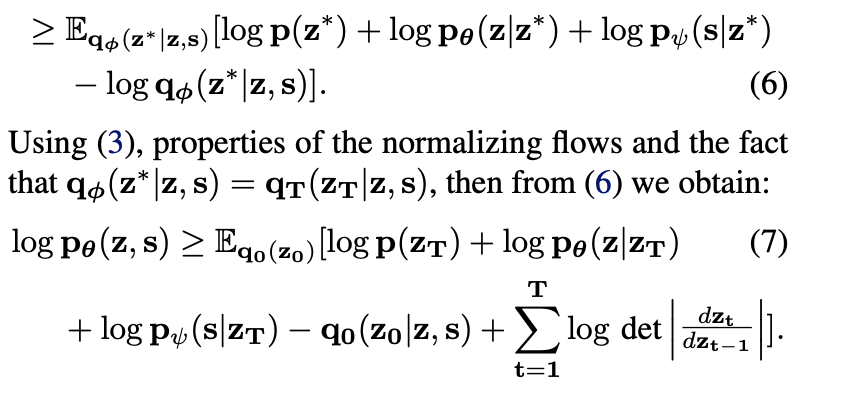

In [16]:
from tensorflow.keras.losses import MSE, categorical_crossentropy
def multinomial_loss_function(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t, beta=1.0, gamma=1.0): 
    """
    :param z_pred: shape: (batch_size, latent_dim), real valued, mean of p_theta(z|z*)
    :param z:       shape (batch_size, latent_dim), original z
    
    :param s_logit: shape: (batch_size, s_digit_dim + s_rot_dim), real valued logits, first 10 cols contain digit, rest are rot
    :param s:       shape: (batch_size, s_digit_dim + s_rot_dim), concated one-h encoding of digit and rot info
    
    :param z_0: first stochastic latent variable
    :param log_q_z0: log denisty of z_0
    
    :param z_t: last stochastic latent variable
    :param ldj: log det jacobian
    
    Note: elbo = log_p_zt + log_p_theta + log_p_psi - log_q_z0 + log_dets    [loss = -elbo]
    """
    
    
    log_p_zt = log_normal_pdf(z_t, mean=0.,  logvar=0.)
    
    log_p_theta = log_normal_pdf(z, mean=z_pred, logvar=0.) #log_normal_pdf(z, mean=z_pred, logvar=0.)
    
    digit_p = -categorical_crossentropy(s[0], s_pred[0], from_logits=True)
    thick_p = log_normal_pdf(s[1], mean=s_pred[1], logvar=0.) #-categorical_crossentropy(s[1], s_pred[1], from_logits=True)
    log_p_psi = digit_p + thick_p 
    
    recons_loss = -(log_p_theta*gamma + log_p_psi)
    kl_loss = log_q_z0 - log_dets - log_p_zt


    loss = recons_loss + kl_loss*beta
    return tf.reduce_mean(loss)
  


def lf_reconstr_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t):     
    log_p_theta = log_normal_pdf(z, mean=z_pred, logvar=0.)
    
    digit_p = -categorical_crossentropy(s[0], s_pred[0], from_logits=True)
    rot_p = log_normal_pdf(s[1], mean=s_pred[1], logvar=0.)
    log_p_psi = tf.add(digit_p, rot_p)
    

    loss = -tf.reduce_mean(log_p_theta + log_p_psi)
    return loss


def lf_kl_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t): 
    log_p_zt = log_normal_pdf(z_t, mean=0.,  logvar=0.)
    loss = log_q_z0 - log_dets - log_p_zt
    return tf.reduce_mean(loss)


metrics = []
metrics.append(('reconstr_loss', lf_reconstr_loss))
metrics.append(('kl_loss', lf_kl_loss))
metrics

[('reconstr_loss',
  <function __main__.lf_reconstr_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t)>),
 ('kl_loss',
  <function __main__.lf_kl_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t)>)]

In [18]:
def build_lens_model(model_type = "filvm",
               latent_dim = 2, 
               flow_depth = 5, 
               inter_dims = [1024, 256, 16], 
               optimizer = tf.keras.optimizers.Adam(), 
               metrics = [], 
               loss_fn = None, 
               beta=1.0, 
               gamma=1.0, 
              ):

    input_z = Input(shape=(z_dim, ), batch_size=batch_size,name='z_in')
    input_s_d = Input(shape=(10, ), batch_size=batch_size,name='s_dig_in')
    input_s_t = Input(shape=(s_dim - 10), batch_size=batch_size,name='s_thc_in')

    recnet1_in = [input_z, input_s_d, input_s_t]
    recnet1_in_cc = tf.keras.layers.concatenate(recnet1_in, axis=1)


    #############  Recnet 1 ##############
    x = Dense(inter_dims[0], activation='relu')(recnet1_in_cc)
    for dim in inter_dims[1:]:
        x = Dense(dim, activation='relu')(x)
    

    w = Dense(flow_dim * flow_depth, name='w')(x)
    u = Dense(flow_dim * flow_depth, name='u')(x)
    b = Dense(1 * flow_depth, name='b')(x)


    z0_mean = Dense(z_dim, name='z0_mean')(x)
    z0_log_var = Dense(z_dim, name='z0_log_var')(x)
    z0, log_q0 = Lambda(sampling2, output_shape=(z_dim,), name='z_0')([z0_mean, z0_log_var])

    recnet1 = Model(recnet1_in, [z0_mean, z0_log_var, z0, log_q0, w, u, b], name='recnet1')


    #############  Srn ##############
    x = Dense(inter_dims[0], activation='relu')(input_z)
    for dim in inter_dims[1:]:
        x = Dense(dim, activation='relu')(x)

    s_d_out = Dense(10, name='s_dig_out',activation="softmax")(x)
    s_t_out = Dense(s_dim-10, name='s_thc_out')(x)

    srn = Model(input_z, (s_d_out, s_t_out), name='srn')


    #####                      Flow             #####   
    pf_layers = [PlanarFlow() for _ in range(flow_depth)]

    
    #####                  Generative model             #####  
    if model_type.lower() == "filvm":
        gen_inputs1 = Input(shape=(z_dim,), batch_size=32, name='zt_full')
        gen_inputs2 = Input(shape=(z_dim,), batch_size=32, name='zt_0')
        gen_inputs3 = Input(shape=(z_dim,), batch_size=32, name='zt_1')

        # theta part
        x = Dense(inter_dims[-1], activation='relu', name="gm_theta_1")(gen_inputs1)
        for dim in reversed(inter_dims[:-1]):
            x = Dense(dim, activation='relu')(x)

        output_z = Dense(z_dim, name="gm_theta_4")(x)  

        # psi part
        output_s_d = Linear(input_dim=1, output_dim=10, name="digit_pred")(tf.expand_dims(gen_inputs2[:,0],axis=1))
        output_s_t = Linear(input_dim=1, output_dim=s_dim-10, name="thick_pred")(tf.expand_dims(gen_inputs3[:,1],axis=1))

        # instantiate generative model
        gm1 = Model(gen_inputs1, output_z, name='generative_model1')
        gm2 = Model(gen_inputs2, output_s_d, name='generative_model2')
        gm3 = Model(gen_inputs3, output_s_t, name='generative_model3')

    elif model_type.lower() == "ilvm":

        gen_inputs1 = Input(shape=(z_dim,), batch_size=32, name='zt_full')

        # theta part
        x = Dense(inter_dims[-1], activation='relu', name="gm_theta_1")(gen_inputs1)
        for dim in reversed(inter_dims[:-1]):
            x = Dense(dim, activation='relu')(x)

        output_z = Dense(z_dim, name="gm_theta_4")(x)  

        # psi part
        output_s_d = Linear(input_dim=z_dim, output_dim=10, name="digit_pred")(gen_inputs1)
        output_s_t = Linear(input_dim=z_dim, output_dim=s_dim-10, name="thick_pred")(gen_inputs1)

        # instantiate generative model
        gm1 = Model(gen_inputs1, output_z, name='generative_model1')
        gm2 = Model(gen_inputs1, output_s_d, name='generative_model2')
        gm3 = Model(gen_inputs1, output_s_t, name='generative_model3')
        
    else:
        raise Exception("Invalid model type!, must be 'filvm' or 'ilvm', got {}".format(model_type))
    
    gm = (gm1, gm2, gm3)
    
    ## Create model ##
    ilvm = FILVM(recnet1, srn, pf_layers, gm,  optimizer, beta=beta, gamma=gamma)
    ilvm.set_metrics(metrics)
    ilvm.set_loss_fn(multinomial_loss_function)
    
    return ilvm
    


In [20]:
ilvm = build_lens_model(loss_fn=multinomial_loss_function, metrics=metrics)
z_dim

8

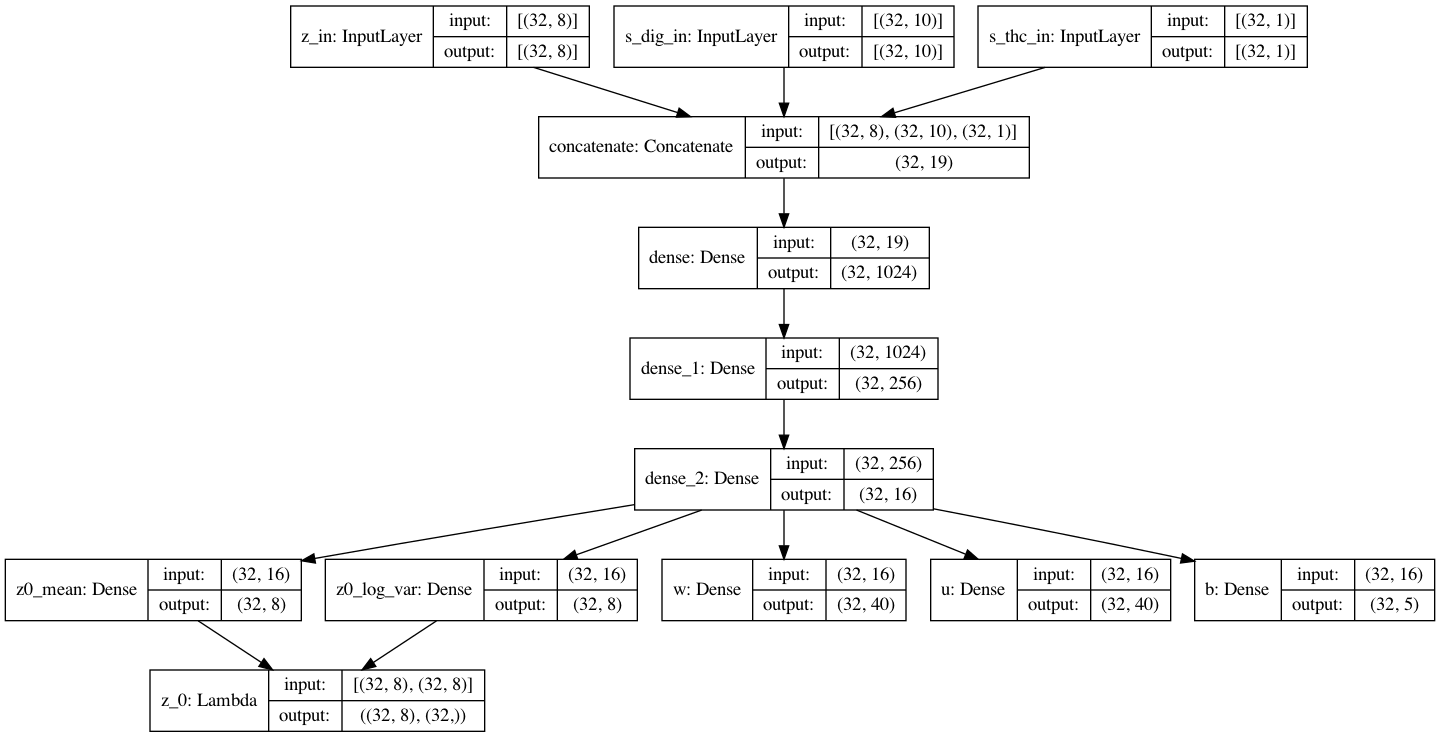

In [21]:
plot_model(ilvm.recnet, show_shapes=True)

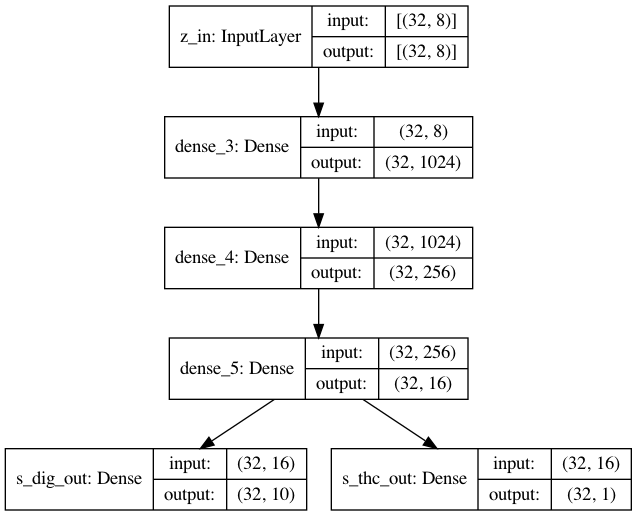

In [22]:
plot_model(ilvm.srn, show_shapes=True)

In [23]:
# Planar flows

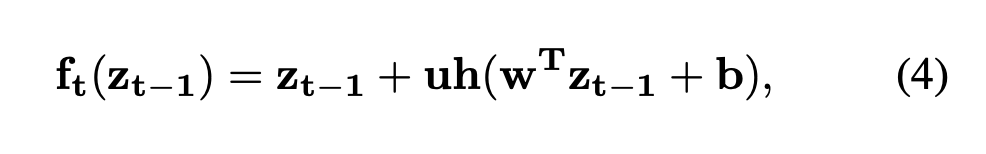 

h is tanh; w,u are vectors; b is scalar

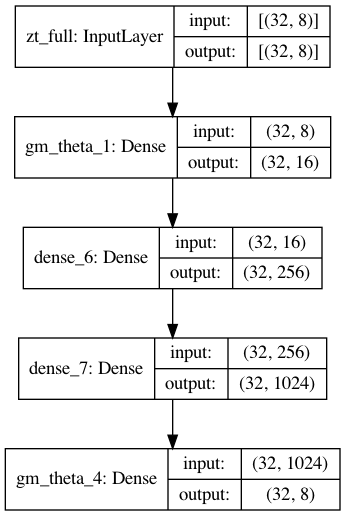

In [24]:
plot_model(ilvm.gm1, show_shapes=True)

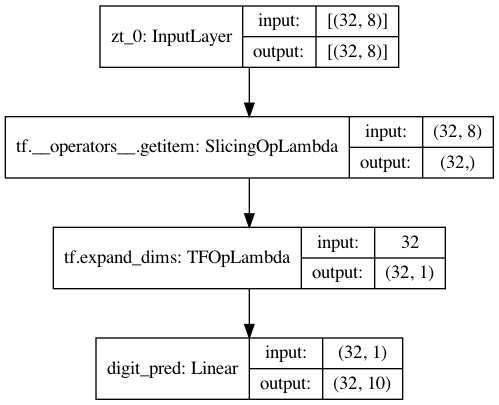

In [25]:
plot_model(ilvm.gm2, show_shapes=True)

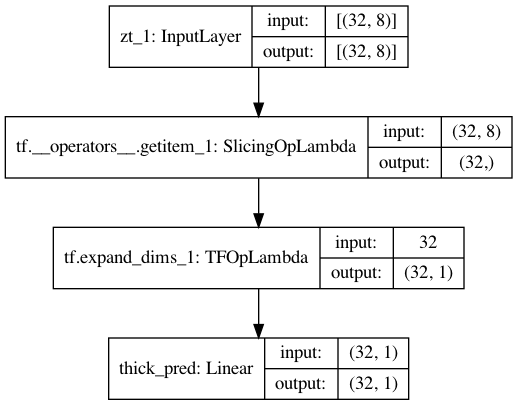

In [26]:
plot_model(ilvm.gm3, show_shapes=True)

In [28]:
param_search = dict(flow_depth = flow_depth_options, 
                     inter_dims = inter_dims_options, 
                     optimizer = optimizer_options, 
                     beta= beta_options, 
                     gamma= gamma_options)




param_list = param_search_to_list(param_search)
len(param_list), param_list[0]

(1,
 {'gamma': 2.0,
  'beta': 0.5,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x10430c4f0>,
  'inter_dims': [1024, 128, 32],
  'flow_depth': 5})

In [29]:
trained = []

In [30]:
watch =["cv_full_loss"]

for rep in range(reps):
    for params in param_list:
        for w in watch:

            id_str = make_id(params) + "--{}--{}".format(w, rep)
            print("running:", id_str)

            log_dir = "{}/{}".format(root_logdir, id_str)
            os.makedirs(log_dir, exist_ok=True)

            ilvm = build_lens_model(model_type=lens_model, **params,loss_fn=multinomial_loss_function, metrics=metrics)

            trained.append((id_str, ilvm)) 

            ilvm.fit(epochs, log_dir, ds1=ds1, ds2=ds2, ds_test=ds_test, batch_size=BATCH_SIZE,
                      show=False, plot_freq=5, early_stop=EARLY_STOP, watch=w)
            
#             walk_ld(ilvm, xrng= (-3, 3), yrng = (-3, 3), n= 60, figsize=(16, 16), model_name=log_dir )
            
#             n_ep = len(ilvm.track["cv_full_loss"])
            
#             make_plots((z_test, s_digit_test, s_thick_test), ilvm, log_dir, n_ep,
#                    prefixs=["digit", "thick_d", "thick_raw"], cs=[y_test, thicks_d_test, raw_thick_scores_test])

#             make_plots(z_test, ilvm, log_dir, n_ep, 
#                prefixs=["digit (no s)", "thick_d (no s)", "thick_raw (no s)"], cs=[y_test, thicks_d_test, raw_thick_scores_test])
            

running: dep-5--inr-1024_128_32--opt-Adam--b-0_5--g-2_0--cv_full_loss--0
Epoch 1 Batch 0 Loss 1 158.1707
tr1_reconstr_loss 146.91954
tr1_kl_loss 0.22270033


Epoch 1 Batch 0 Loss 2 169.2933
tr2_reconstr_loss 158.23294
tr2_kl_loss 0.07468799
tr2_loss_srn_d 0.09022868
tr2_loss_srn_t 7.2145724
tr2_loss_srn 7.304801


Epoch 1 Loss 12037.6572
********** CV **********
Epoch 1 Loss 6452.6025
cv_reconstr_loss 174.21
cv_kl_loss 1.6186783
Epoch 2 Batch 0 Loss 1 194.8737
tr1_reconstr_loss 184.2916
tr1_kl_loss 2.037107


Epoch 2 Batch 0 Loss 2 158.0853
tr2_reconstr_loss 147.16893
tr2_kl_loss 2.1180677
tr2_loss_srn_d 0.084801756
tr2_loss_srn_t 6.616951
tr2_loss_srn 6.7017527


Epoch 2 Loss 11947.8770
********** CV **********
Epoch 2 Loss 6423.1084
cv_reconstr_loss 159.56906
cv_kl_loss 3.1726615


Full Time taken for 2 epochs is 17.726943969726562 sec




### View trained ilvm

dep-5--inr-1024_128_32--opt-Adam--b-0_5--g-2_0--cv_full_loss--0


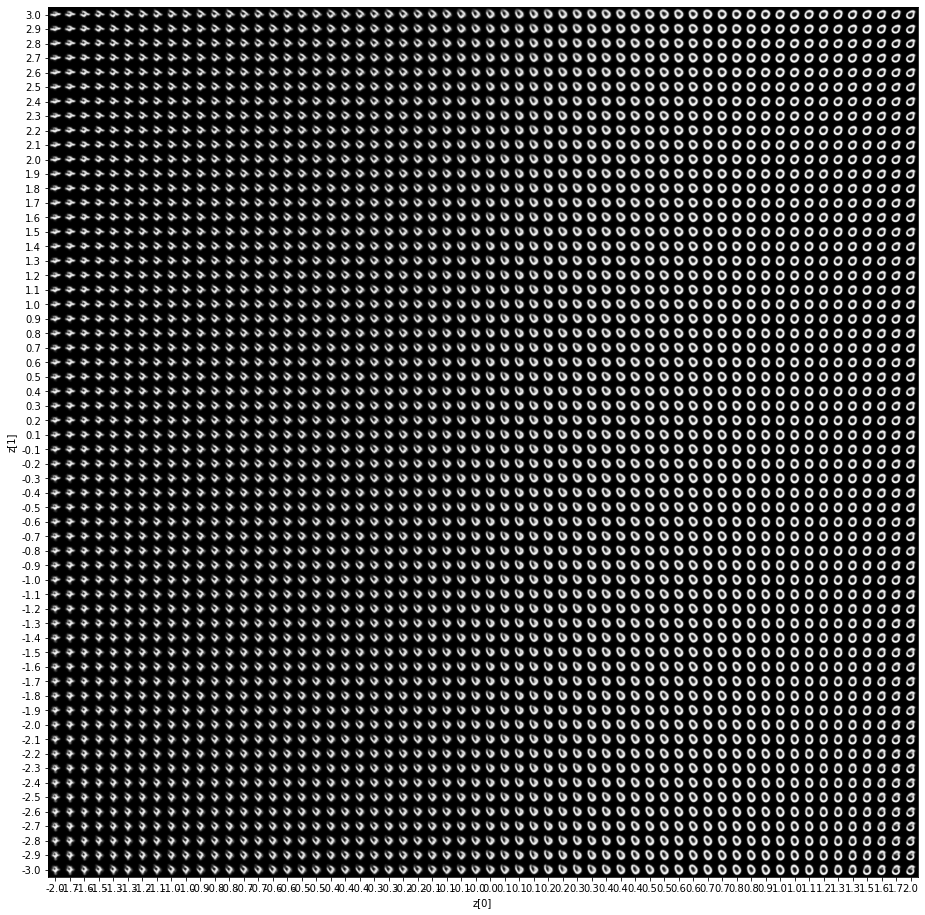

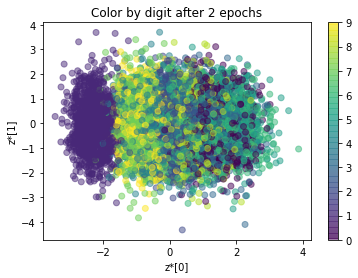

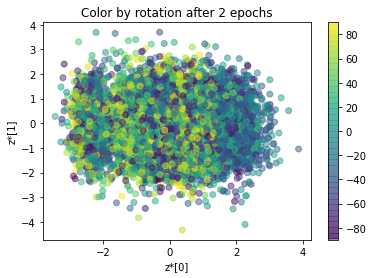

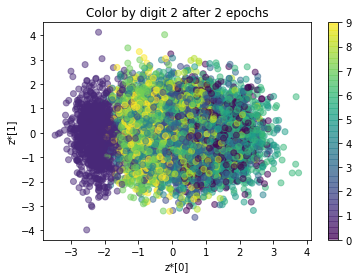

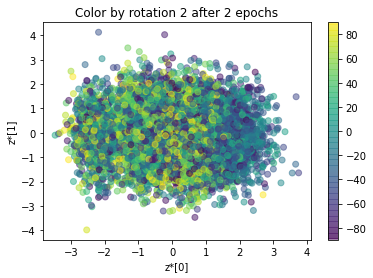

<Figure size 432x288 with 0 Axes>

In [35]:

show = 4
key = "cv_full_loss"

def model_sort_key(x):
    try:
        id_str, model = x
        return min(model.track[key])
    except:
        return 1e10

    
    
for i, (id_str, model) in enumerate(sorted(trained, key=model_sort_key)):
    print(id_str)

    n_ep = len(model.track[key])

    walk_ld(model, decoder=decoder,n= 60, figsize=(16, 16), model_name=log_dir )
    
    make_plots((z_test, s_digit_test, s_thick_test), model, log_dir, n_ep, save=False, show=show, 
       prefixs=["digit", "rotation"], cs=[y_test, rots_test])


    make_plots(z_test, model, log_dir, n_ep, save=False, show=show, 
        prefixs=["digit 2", "rotation 2"], cs=[y_test, rots_test])

    if i >show-2:
        break


In [36]:

find = "dep-10--inr-1024_128_32--opt-Adam--b-0_5--k-0_5--g-2_0--cv_full_loss--0"\

for (id_str, ilvm) in trained:
    print(id_str)
    if id_str == find:
        print("found")
        
        break

dep-5--inr-1024_128_32--opt-Adam--b-0_5--g-2_0--cv_full_loss--0


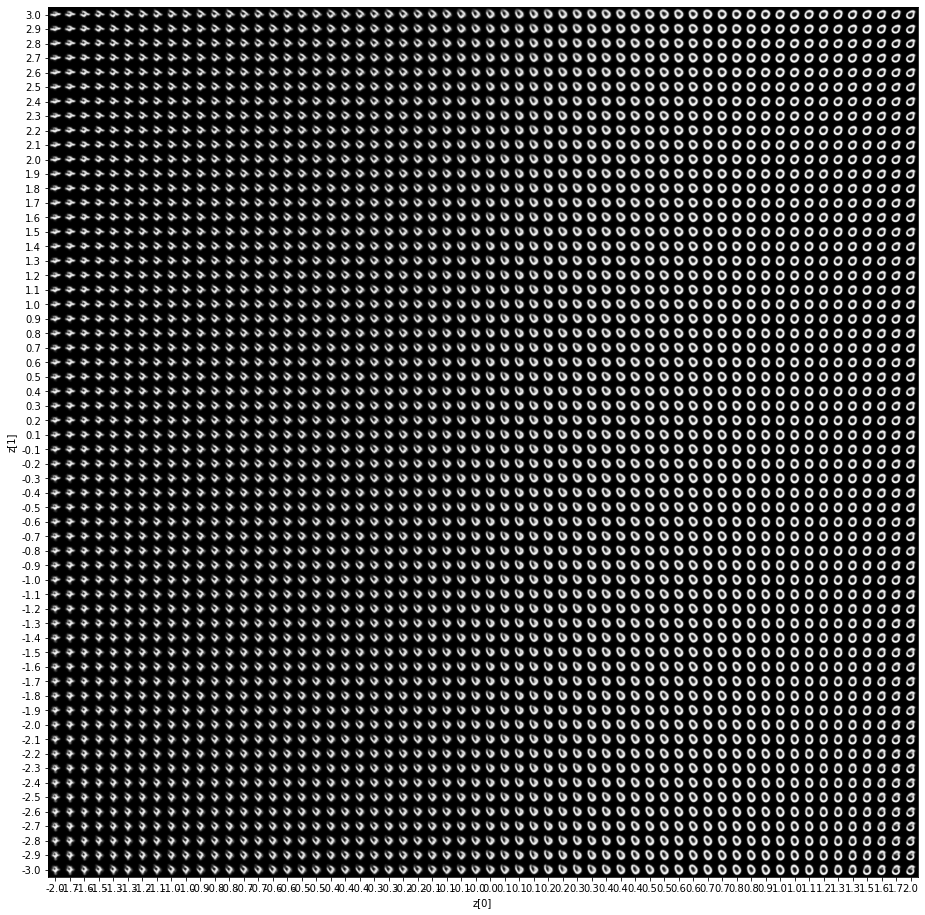

In [38]:
walk_ld(ilvm, decoder=decoder,  n= 60, figsize=(16, 16), model_name=save_loc)

In [39]:
save_ilvm(filvm, save_loc + "/lens_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: good_ilvm2/models/recnet1/assets
INFO:tensorflow:Assets written to: good_ilvm2/models/srn/assets
INFO:tensorflow:Assets written to: good_ilvm2/models/generative_model1/assets
INFO:tensorflow:Assets written to: good_ilvm2/models/generative_model2/assets
INFO:tensorflow:Assets written to: good_ilvm2/models/generative_model3/assets
